In [1]:
from itertools import product
from pathlib import Path
from cytoolz import concat, valmap
from mappy import fastx_read
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from libsnp import load_counts_from_joint_vcf, counts2freqs

/tmp/ipykernel_135104/2388610157.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
analyses = {}
for path in list(Path("../jointcall_results/mapped_on_SKV38_Basile/realigned").glob("snp_tables_*")):
    md5hash = path.name.split("_")[-1]
    tables = sorted(path.glob("*.tsv"))
    analyses[md5hash] = {
        "_".join(table.name.split("_")[:-1]): pd.read_csv(
            table, sep="\t", index_col=0, header=[0, 1])
        for table in tables}

In [3]:
from operator import and_ as intersect
from operator import or_ as union
from itertools import combinations
from functools import reduce

sample_sets = {
    md5hash: set(tables_dict.keys())
    for (md5hash, tables_dict) in analyses.items()}

reduce(intersect, sample_sets.values())

set()

In [4]:
if False:
    for (h1, h2) in combinations(sample_sets.keys(), 2):
        print(h1, h2)
        print(sorted(intersect(sample_sets[h1], sample_sets[h1])))

In [5]:
use_analyses = []
for (md5hash, sample_set) in sample_sets.items():
    if "O_D6_P84" in sample_set:
        use_analyses.append(md5hash)
        print(md5hash, len(sample_set))
use_analyses

7ffe0d28c35282892f64478ef4ad550b 24
a2634fac5f059556d2a148868e7b70c1 149
7476a6e0dbb539500f0d2ed99a8ade5f 78


['7ffe0d28c35282892f64478ef4ad550b',
 'a2634fac5f059556d2a148868e7b70c1',
 '7476a6e0dbb539500f0d2ed99a8ade5f']

In [6]:
df1 = analyses[use_analyses[0]]["O_D6_P84"]
df1.columns = df1.columns.get_level_values(0)
print(df1.shape)

(1291, 8)


In [7]:
df2 = analyses[use_analyses[1]]["O_D6_P84"]
df2.columns = df2.columns.get_level_values(0)
print(df2.shape)

(8116, 8)


In [8]:
df3 = analyses[use_analyses[2]]["O_D6_P84"]
df3.columns = df3.columns.get_level_values(0)
print(df3.shape)

(2298, 8)


In [9]:
df3.loc[df3["pos"].isin({
    26655,
    27056,
    27071,
    111332,
    587780,
    1042042,
    1372493,
    1499814,
    1549587,
    1550434,
    2021963,
    2119154})][["pos", "alt_freq"]]

pos  alt_freq
SKV38_Basile_26655_C_G                                26655  0.000000
SKV38_Basile_27056_C_T                                27056  0.000000
SKV38_Basile_27071_C_T                                27071  0.996616
SKV38_Basile_111332_C_T                              111332  0.996255
SKV38_Basile_587780_G_A                              587780  0.647658
SKV38_Basile_1042042_C_T                            1042042  0.064885
SKV38_Basile_1372493_C_A                            1372493  0.069565
SKV38_Basile_1499814_T_G                            1499814  0.070370
SKV38_Basile_1549587_GATTTGCTATCA_GATTTGCTATCAT...  1549587  0.000000
SKV38_Basile_1550434_G_A                            1550434  0.992509
SKV38_Basile_2021963_CGTTTCTGTTTCTGTTTCTGTTTCTG...  2021963  0.008086
SKV38_Basile_2119154_TG_GT                          2119154  0.085236

In [10]:
outdir = Path("..").joinpath("Post_process_SNP_results")
outdir.mkdir(exist_ok=True, parents=True)

In [11]:
ref_fasta = "../data/Reference/SKV38_Basile.fa"
chr_sizes = {
    name: len(seq)
    for (name, seq, *_) in fastx_read(ref_fasta)}

chromosomes = list(chr_sizes.keys())

In [12]:
vcf_path = "../jointcall_results/mapped_on_SKV38_Basile/realigned/FB_a2634fac5f059556d2a148868e7b70c1/FB.snpEFF.vcf.gz"
counts = load_counts_from_joint_vcf(
    vcf_path, chromosomes,
    biallelic_only=True,
    snp_only=False,
    allow_mnp=True,
    extra_annots=["Annotation_Impact"])
# Sorry one more thing on looking at it. I am completely forgot about a tube switch
# which I remembered happening during my analysis. I supected it before I sent them
# for sequencing but it was confirmed upon sequencing. Osmo_delta1 and Osmo_WT6 are
# reversed. Sorry I completely forgot about this and forgot to change the file names. 
od1A = counts.copy()[("Osmo_Delta1", "AO")]
od1R = counts.copy()[("Osmo_Delta1", "RO")]
ow6A = counts.copy()[("Osmo_WT6", "AO")]
ow6R = counts.copy()[("Osmo_WT6", "RO")]
counts[("Osmo_Delta1", "AO")] = ow6A
counts[("Osmo_Delta1", "RO")] = ow6R
counts[("Osmo_WT6", "AO")] = od1A
counts[("Osmo_WT6", "RO")] = od1R
freqs = counts2freqs(counts)
len(freqs)

8116

In [37]:
snp_selection = pd.read_table(
    "../jointcall_results/mapped_on_SKV38_Basile/realigned/FB_a2634fac5f059556d2a148868e7b70c1/snp_selection.tsv",
    index_col=0).index

In [13]:
freqs.index.names

FrozenList(['SNP', 'chrom', 'pos', 'ref', 'alt', 'annot', 'gene_id', 'EFF_class', 'EFF_mut', 'Annotation_Impact'])

In [14]:
freqs.reset_index()["EFF_class"].value_counts()

EFF_class
missense_variant                                      4662
intergenic_region                                     1558
synonymous_variant                                     844
stop_gained                                            605
frameshift_variant                                     392
initiator_codon_variant                                 21
stop_lost&splice_region_variant                         20
conservative_inframe_deletion                            5
start_lost                                               2
frameshift_variant&start_lost                            2
frameshift_variant&stop_gained                           1
frameshift_variant&stop_lost&splice_region_variant       1
stop_retained_variant&splice_region_variant              1
disruptive_inframe_deletion                              1
frameshift_variant&splice_region_variant                 1
Name: count, dtype: int64

In [15]:
freqs.reset_index()["Annotation_Impact"].value_counts()

Annotation_Impact
MODERATE    4668
MODIFIER    1558
HIGH        1024
LOW          866
Name: count, dtype: int64

In [16]:
sample_lists = valmap(sorted, {
    f"{culture}_{genotype}": freqs.columns[
        freqs.columns.str.contains(f"^{culture}_{genotype}[^_]")]
    for (culture, genotype)
    in product(["SK", "NS", "Osmo"], ["WT", "Delta"])
})
selection = list(concat(sample_lists.values()))
len(selection)

35

In [17]:
[samplename for samplename in freqs.columns if samplename[-3:] == "_P0"]

['O_D6_P0', 'SK_D3_P0', 'SK_WT_P0']

In [18]:
all_freqs = freqs.reset_index().set_index("SNP")
to_exclude = all_freqs.loc[
    all_freqs["EFF_class"].isin(
        {"intergenic_region", "synonymous_variant"})].index
len(to_exclude)

2402

In [19]:
in_mutant_P0 = all_freqs.loc[(all_freqs[["SK_D3_P0", "O_D6_P0"]] > 0.05).any(axis=1)].index
len(in_mutant_P0), len(to_exclude.union(in_mutant_P0))

(7, 2403)

In [20]:
all_freqs.loc[in_mutant_P0.difference(to_exclude)]

sample                               chrom      pos  ref  alt  \
SNP                                                             
SKV38_Basile_1641463_TGC_TGT  SKV38_Basile  1641463  TGC  TGT   

sample                                                                    annot  \
SNP                                                                               
SKV38_Basile_1641463_TGC_TGT  TGT|missense_variant|MODERATE|recQ|FNLLGLLA_01...   

sample                               gene_id         EFF_class  \
SNP                                                              
SKV38_Basile_1641463_TGC_TGT  FNLLGLLA_01502  missense_variant   

sample                                      EFF_mut Annotation_Impact  \
SNP                                                                     
SKV38_Basile_1641463_TGC_TGT  c.1852G>A|p.Ala618Thr          MODERATE   

sample                        NS_Delta1  ...  SK_WT_P54  SK_WT_P56  SK_WT_P60  \
SNP                                      ...                                    
SKV38_Basile_1641463_TGC_TGT        1.0  ...        0.0        0.0        0.0   

sample                        SK_WT_P62  SK_WT_P66  SK_WT_P68  SK_WT_P7  \
SNP                                                                       
SKV38_Basile_1641463_TGC_TGT        0.0        0.0        0.0       0.0   

sample                        SK_WT_P72  SK_WT_P76  SK_WT_P85  
SNP                                                            
SKV38_Basile_1641463_TGC_TGT        0.0        0.0        0.0  

[1 rows x 158 columns]

In [21]:
all_freqs.loc[in_mutant_P0.intersection(to_exclude)]

sample                             chrom      pos ref alt  \
SNP                                                         
SKV38_Basile_592581_T_C     SKV38_Basile   592581   T   C   
SKV38_Basile_606636_C_A     SKV38_Basile   606636   C   A   
SKV38_Basile_1372493_C_A    SKV38_Basile  1372493   C   A   
SKV38_Basile_1466888_G_T    SKV38_Basile  1466888   G   T   
SKV38_Basile_1800307_C_G    SKV38_Basile  1800307   C   G   
SKV38_Basile_2119154_TG_GT  SKV38_Basile  2119154  TG  GT   

sample                                                                  annot  \
SNP                                                                             
SKV38_Basile_592581_T_C     C|synonymous_variant|LOW|oprF|FNLLGLLA_00518|t...   
SKV38_Basile_606636_C_A     A|intergenic_region|MODIFIER|FNLLGLLA_00524-FN...   
SKV38_Basile_1372493_C_A    A|intergenic_region|MODIFIER|ywqE-FNLLGLLA_012...   
SKV38_Basile_1466888_G_T    T|intergenic_region|MODIFIER|mopII-yhhS_2|FNLL...   
SKV38_Basile_1800307_C_G    G|intergenic_region|MODIFIER|FNLLGLLA_01675-qu...   
SKV38_Basile_2119154_TG_GT  GT|intergenic_region|MODIFIER|gyrA-FNLLGLLA_01...   

sample                                            gene_id           EFF_class  \
SNP                                                                             
SKV38_Basile_592581_T_C                    FNLLGLLA_00518  synonymous_variant   
SKV38_Basile_606636_C_A     FNLLGLLA_00524-FNLLGLLA_00532   intergenic_region   
SKV38_Basile_1372493_C_A    FNLLGLLA_01256-FNLLGLLA_01257   intergenic_region   
SKV38_Basile_1466888_G_T    FNLLGLLA_01341-FNLLGLLA_01345   intergenic_region   
SKV38_Basile_1800307_C_G    FNLLGLLA_01675-FNLLGLLA_01676   intergenic_region   
SKV38_Basile_2119154_TG_GT  FNLLGLLA_01948-FNLLGLLA_01949   intergenic_region   

sample                     EFF_mut Annotation_Impact  NS_Delta1  ...  \
SNP                                                              ...   
SKV38_Basile_592581_T_C        NaN               LOW   1.000000  ...   
SKV38_Basile_606636_C_A        NaN          MODIFIER   0.040816  ...   
SKV38_Basile_1372493_C_A       NaN          MODIFIER   0.062092  ...   
SKV38_Basile_1466888_G_T       NaN          MODIFIER   0.026316  ...   
SKV38_Basile_1800307_C_G       NaN          MODIFIER   0.093548  ...   
SKV38_Basile_2119154_TG_GT     NaN          MODIFIER   0.123123  ...   

sample                      SK_WT_P54  SK_WT_P56  SK_WT_P60  SK_WT_P62  \
SNP                                                                      
SKV38_Basile_592581_T_C      0.000000   0.000000   0.000000   0.000000   
SKV38_Basile_606636_C_A      0.000000   0.012195   0.000000   0.000000   
SKV38_Basile_1372493_C_A     0.000000   0.010638   0.011976   0.004329   
SKV38_Basile_1466888_G_T     0.000000   0.000000   0.000000   0.000000   
SKV38_Basile_1800307_C_G     0.108635   0.097222   0.111111   0.122642   
SKV38_Basile_2119154_TG_GT   0.000000   0.000000   0.000000   0.000000   

sample                      SK_WT_P66  SK_WT_P68  SK_WT_P7  SK_WT_P72  \
SNP                                                                     
SKV38_Basile_592581_T_C      0.000000   0.000000  0.000000   0.000000   
SKV38_Basile_606636_C_A      0.010204   0.011628  0.000000   0.007634   
SKV38_Basile_1372493_C_A     0.007380   0.006494  0.000000   0.004464   
SKV38_Basile_1466888_G_T     0.000000   0.000000  0.000000   0.013699   
SKV38_Basile_1800307_C_G     0.113150   0.141892  0.134752   0.119681   
SKV38_Basile_2119154_TG_GT   0.000000   0.000000  0.000000   0.000000   

sample                      SK_WT_P76  SK_WT_P85  
SNP                                               
SKV38_Basile_592581_T_C      0.000000   0.000000  
SKV38_Basile_606636_C_A      0.000000   0.061728  
SKV38_Basile_1372493_C_A     0.016043   0.084746  
SKV38_Basile_1466888_G_T     0.000000   0.022727  
SKV38_Basile_1800307_C_G     0.102804   0.135647  
SKV38_Basile_2119154_TG_GT   0.000000   0.000000  

[6 rows x 158 columns]

In [22]:
all_freqs.loc[all_freqs["gene_id"] == "FNLLGLLA_00518"][["SK_D3_P0", "O_D6_P0"]]

sample                   SK_D3_P0   O_D6_P0
SNP                                        
SKV38_Basile_592581_T_C       1.0  0.993711

In [23]:
high_freqs = freqs.loc[
    (freqs > 0.5).any(axis=1)].reset_index().set_index("SNP")
to_rescue = high_freqs.loc[
    high_freqs["EFF_class"].isin(
        {"intergenic_region", "synonymous_variant"})].index
len(to_rescue)

10

In [24]:
#all_freqs.loc[to_rescue]

In [25]:
pre_freq_filter_to_keep = all_freqs.index.difference(to_exclude.difference(to_rescue).union(in_mutant_P0))
len(pre_freq_filter_to_keep)

5722

In [26]:
pre_freq_filter_freqs_selection = all_freqs.loc[
    pre_freq_filter_to_keep, [
        "chrom", "pos", "annot", "gene_id", "EFF_class", "Annotation_Impact", *selection]]

In [27]:
pre_freq_filter_freqs_selection.set_index(
    [
        "chrom", "pos", "annot", "gene_id", "EFF_class", "Annotation_Impact"],
    append=True).to_csv(
        outdir.joinpath("SNP_freqs_selection.tsv"), sep="\t")

In [28]:
freq_filtered_freqs = pre_freq_filter_freqs_selection.loc[
    (pre_freq_filter_freqs_selection[selection] > 0.25).any(axis=1)].sort_values(
        ["chrom", "pos"])
len(freq_filtered_freqs)

97

In [40]:
len(
    freq_filtered_freqs.loc[
    freq_filtered_freqs.index.intersection(snp_selection)])

92

In [29]:
max_freq_by_impact = freq_filtered_freqs.set_index(
    ["chrom", "pos", "annot", "gene_id", "EFF_class", "Annotation_Impact"]).groupby(
    ["gene_id", "Annotation_Impact"]).max()
max_freq_by_impact.head(3)

sample                              SK_WT1    SK_WT2    SK_WT3    SK_WT4  \
gene_id        Annotation_Impact                                           
FNLLGLLA_00012 HIGH               0.000000  0.413934  0.000000  0.000000   
FNLLGLLA_00020 MODERATE           0.000000  0.000000  0.000000  0.000000   
FNLLGLLA_00021 HIGH               0.003584  0.002381  0.003431  0.002066   

sample                             SK_WT5    SK_WT6  SK_Delta1  SK_Delta2  \
gene_id        Annotation_Impact                                            
FNLLGLLA_00012 HIGH               0.00000  0.000000   0.000000        0.0   
FNLLGLLA_00020 MODERATE           0.00000  0.000000   0.470199        0.0   
FNLLGLLA_00021 HIGH               0.00404  0.001515   0.002725        1.0   

sample                            SK_Delta3  SK_Delta4  ...  Osmo_WT2  \
gene_id        Annotation_Impact                        ...             
FNLLGLLA_00012 HIGH                0.000000        0.0  ...  0.000000   
FNLLGLLA_00020 MODERATE            0.000000        0.0  ...  0.000000   
FNLLGLLA_00021 HIGH                0.942708        0.0  ...  0.003205   

sample                            Osmo_WT3  Osmo_WT4  Osmo_WT5  Osmo_WT6  \
gene_id        Annotation_Impact                                           
FNLLGLLA_00012 HIGH               0.000000  0.000000   0.00000       0.0   
FNLLGLLA_00020 MODERATE           0.001672  0.000000   0.00000       0.0   
FNLLGLLA_00021 HIGH               0.001931  0.003448   0.00165       0.0   

sample                            Osmo_Delta1  Osmo_Delta3  Osmo_Delta4  \
gene_id        Annotation_Impact                                          
FNLLGLLA_00012 HIGH                       0.0     0.000000     0.000000   
FNLLGLLA_00020 MODERATE                   0.0     0.000000     0.000000   
FNLLGLLA_00021 HIGH                       1.0     0.362105     0.004024   

sample                            Osmo_Delta5  Osmo_Delta6  
gene_id        Annotation_Impact                            
FNLLGLLA_00012 HIGH                       0.0     0.000000  
FNLLGLLA_00020 MODERATE                   0.0     0.000000  
FNLLGLLA_00021 HIGH                       1.0     0.996616  

[3 rows x 35 columns]

In [41]:
max_freq_by_impact_bis = freq_filtered_freqs.loc[
    freq_filtered_freqs.index.intersection(snp_selection)].set_index(
    ["chrom", "pos", "annot", "gene_id", "EFF_class", "Annotation_Impact"]).groupby(
    ["gene_id", "Annotation_Impact"]).max()
max_freq_by_impact.head(3)

sample                              SK_WT1    SK_WT2    SK_WT3    SK_WT4  \
gene_id        Annotation_Impact                                           
FNLLGLLA_00012 HIGH               0.000000  0.413934  0.000000  0.000000   
FNLLGLLA_00020 MODERATE           0.000000  0.000000  0.000000  0.000000   
FNLLGLLA_00021 HIGH               0.003584  0.002381  0.003431  0.002066   

sample                             SK_WT5    SK_WT6  SK_Delta1  SK_Delta2  \
gene_id        Annotation_Impact                                            
FNLLGLLA_00012 HIGH               0.00000  0.000000   0.000000        0.0   
FNLLGLLA_00020 MODERATE           0.00000  0.000000   0.470199        0.0   
FNLLGLLA_00021 HIGH               0.00404  0.001515   0.002725        1.0   

sample                            SK_Delta3  SK_Delta4  ...  Osmo_WT2  \
gene_id        Annotation_Impact                        ...             
FNLLGLLA_00012 HIGH                0.000000        0.0  ...  0.000000   
FNLLGLLA_00020 MODERATE            0.000000        0.0  ...  0.000000   
FNLLGLLA_00021 HIGH                0.942708        0.0  ...  0.003205   

sample                            Osmo_WT3  Osmo_WT4  Osmo_WT5  Osmo_WT6  \
gene_id        Annotation_Impact                                           
FNLLGLLA_00012 HIGH               0.000000  0.000000   0.00000       0.0   
FNLLGLLA_00020 MODERATE           0.001672  0.000000   0.00000       0.0   
FNLLGLLA_00021 HIGH               0.001931  0.003448   0.00165       0.0   

sample                            Osmo_Delta1  Osmo_Delta3  Osmo_Delta4  \
gene_id        Annotation_Impact                                          
FNLLGLLA_00012 HIGH                       0.0     0.000000     0.000000   
FNLLGLLA_00020 MODERATE                   0.0     0.000000     0.000000   
FNLLGLLA_00021 HIGH                       1.0     0.362105     0.004024   

sample                            Osmo_Delta5  Osmo_Delta6  
gene_id        Annotation_Impact                            
FNLLGLLA_00012 HIGH                       0.0     0.000000  
FNLLGLLA_00020 MODERATE                   0.0     0.000000  
FNLLGLLA_00021 HIGH                       1.0     0.996616  

[3 rows x 35 columns]

(35, 40)


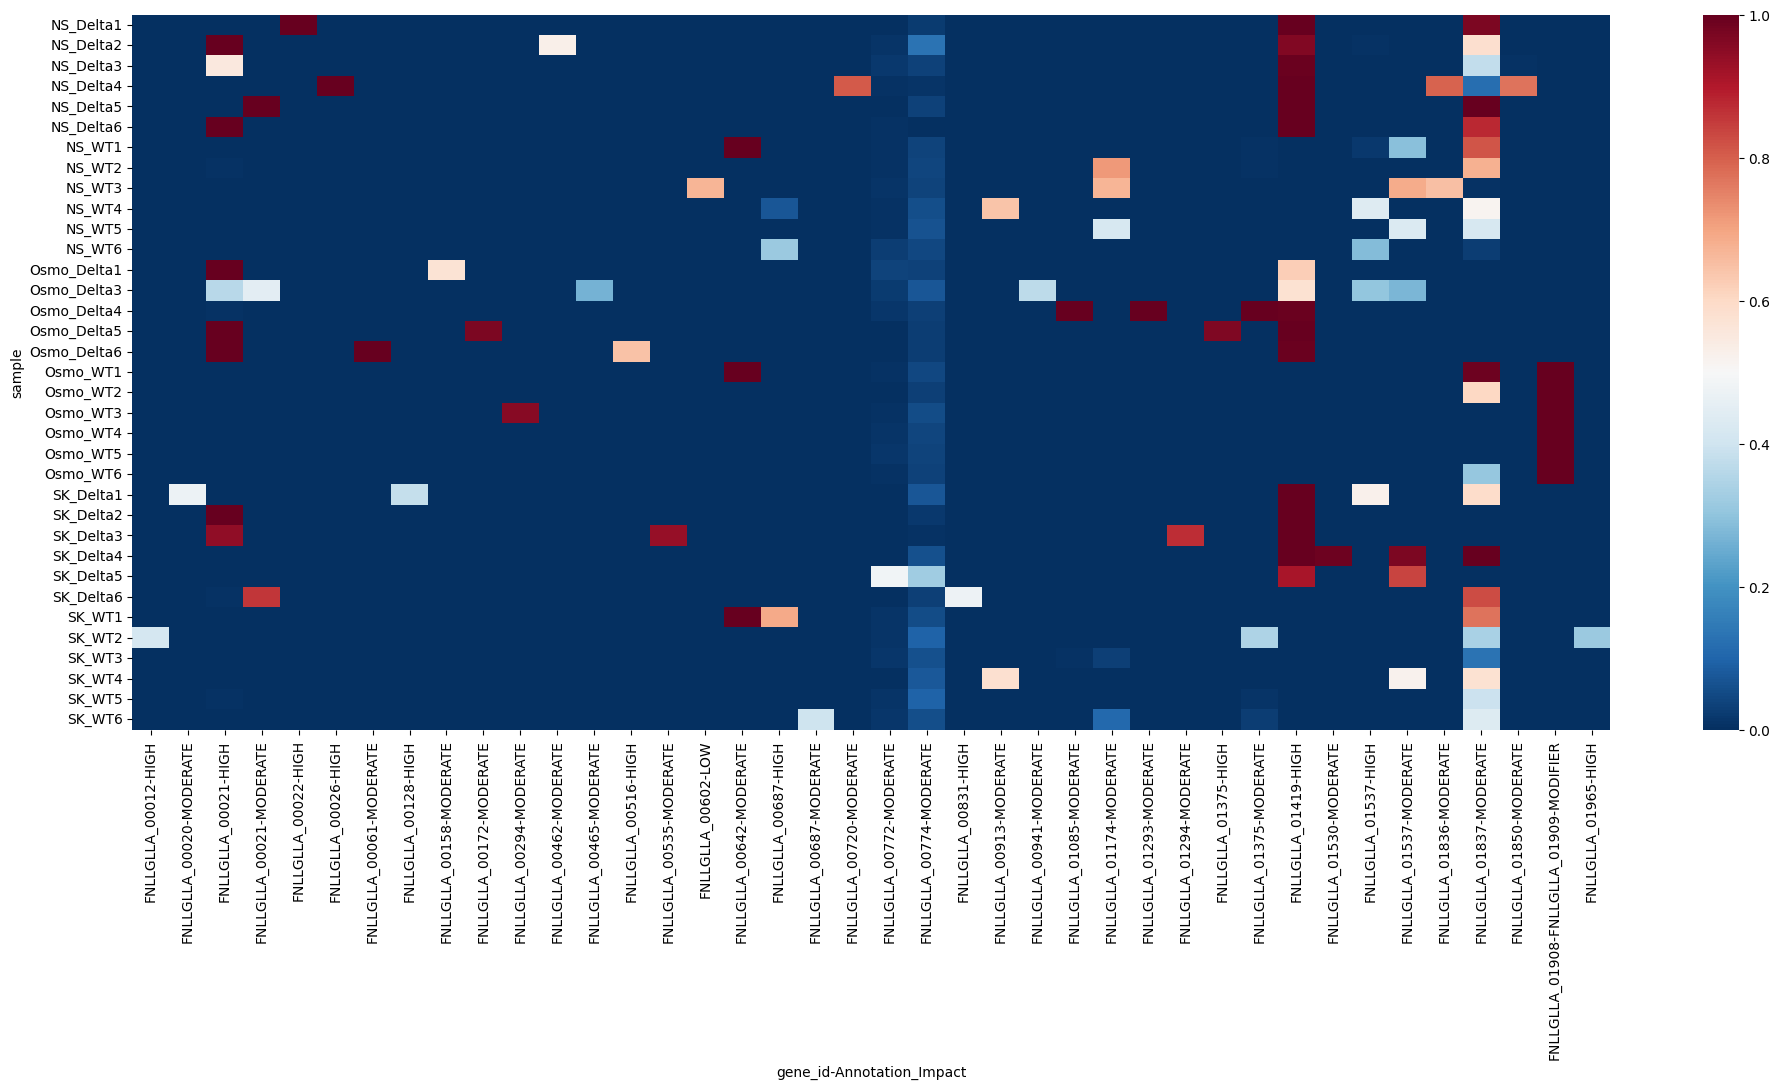

In [30]:
df = max_freq_by_impact.stack().reset_index().set_index(["gene_id", "Annotation_Impact"])
#    index="sample", columns=["gene_id"])
df.columns = ["sample", "max_freq"]
df = df.reset_index().pivot(
    index="sample", columns=["gene_id", "Annotation_Impact"], values="max_freq")
print(df.shape)
df.to_csv(
    outdir.joinpath("SNP_max_freq_by_impact_heatmap_end_points_data.tsv"),
    sep="\t")
fig, ax = plt.subplots(1, 1, figsize=(20, len(selection) // 3))
sns.heatmap(df, ax=ax, cmap="RdBu_r")
plt.tight_layout()
plt.savefig(
    outdir.joinpath("SNP_max_freq_by_impact_heatmap_end_points.png"),
    dpi=300)

(35, 38)


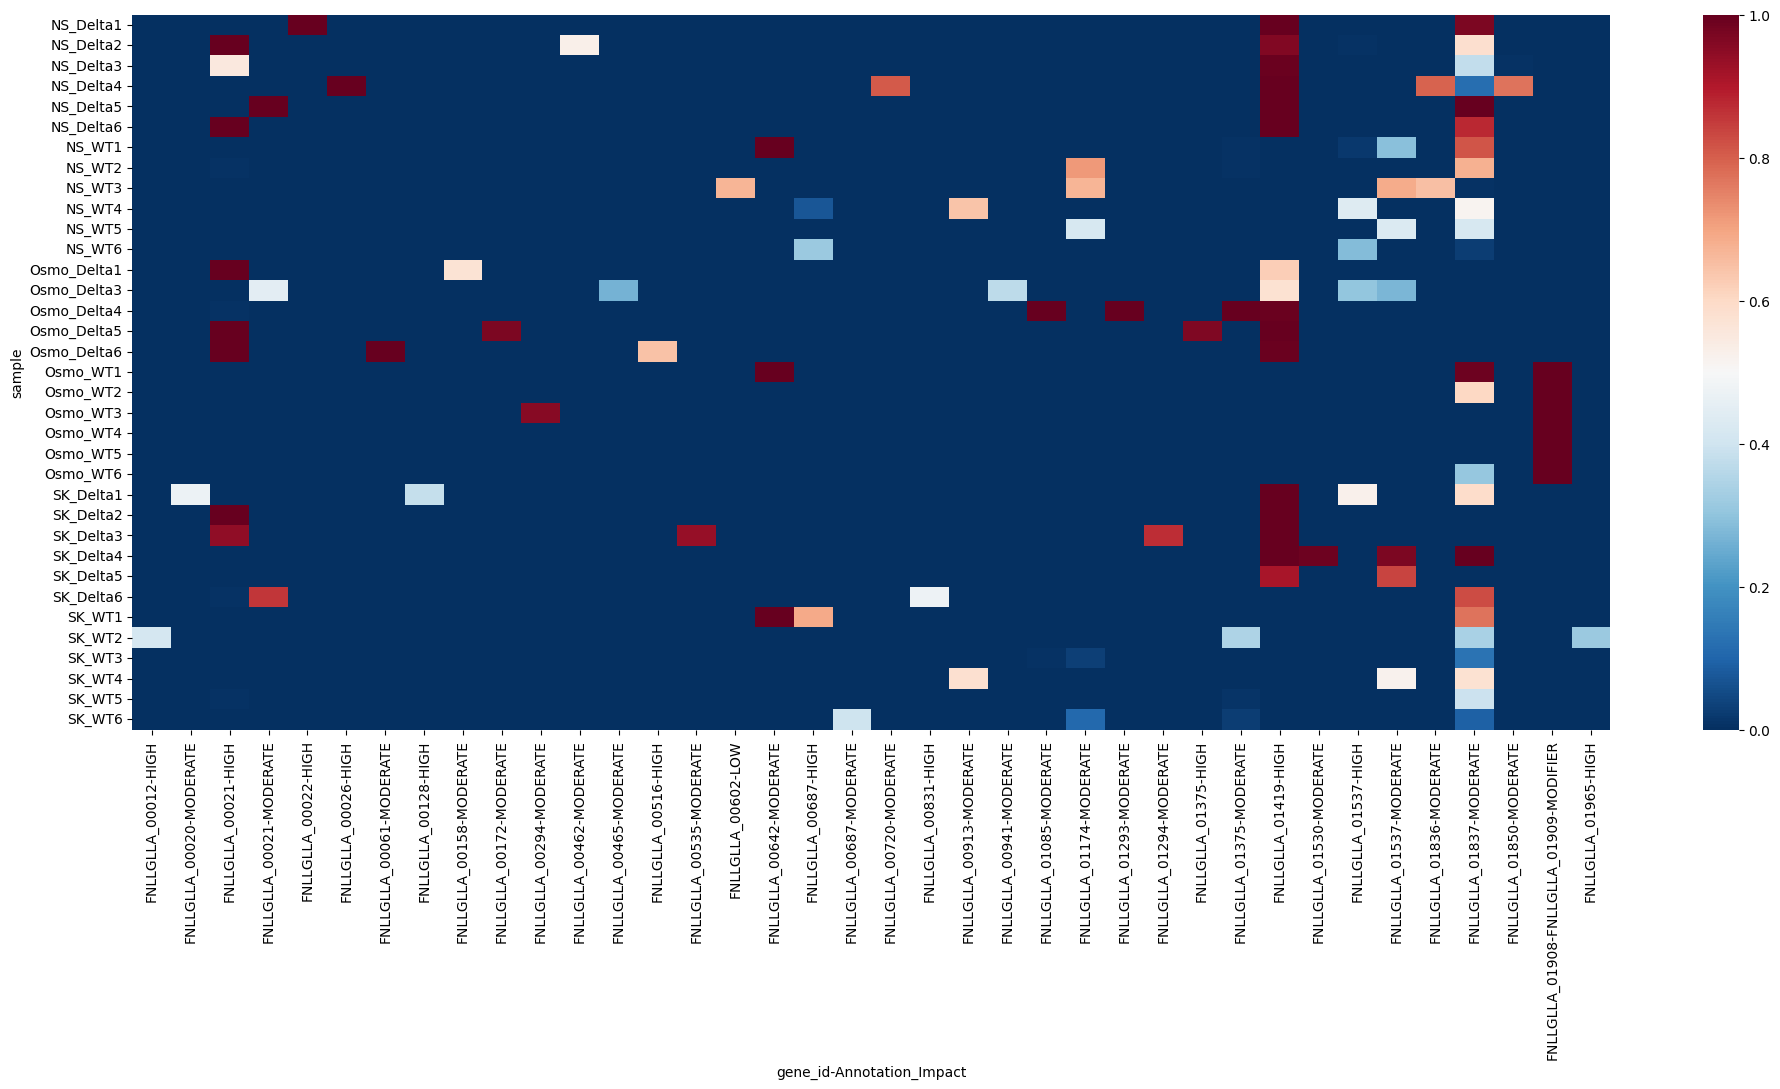

In [42]:
df = max_freq_by_impact_bis.stack().reset_index().set_index(["gene_id", "Annotation_Impact"])
#    index="sample", columns=["gene_id"])
df.columns = ["sample", "max_freq"]
df = df.reset_index().pivot(
    index="sample", columns=["gene_id", "Annotation_Impact"], values="max_freq")
print(df.shape)
df.to_csv(
    outdir.joinpath("SNP_max_freq_by_impact_heatmap_end_points_data_filtered.tsv"),
    sep="\t")
fig, ax = plt.subplots(1, 1, figsize=(20, len(selection) // 3))
sns.heatmap(df, ax=ax, cmap="RdBu_r")
plt.tight_layout()
plt.savefig(
    outdir.joinpath("SNP_max_freq_by_impact_heatmap_end_points_filtered.png"),
    dpi=300)

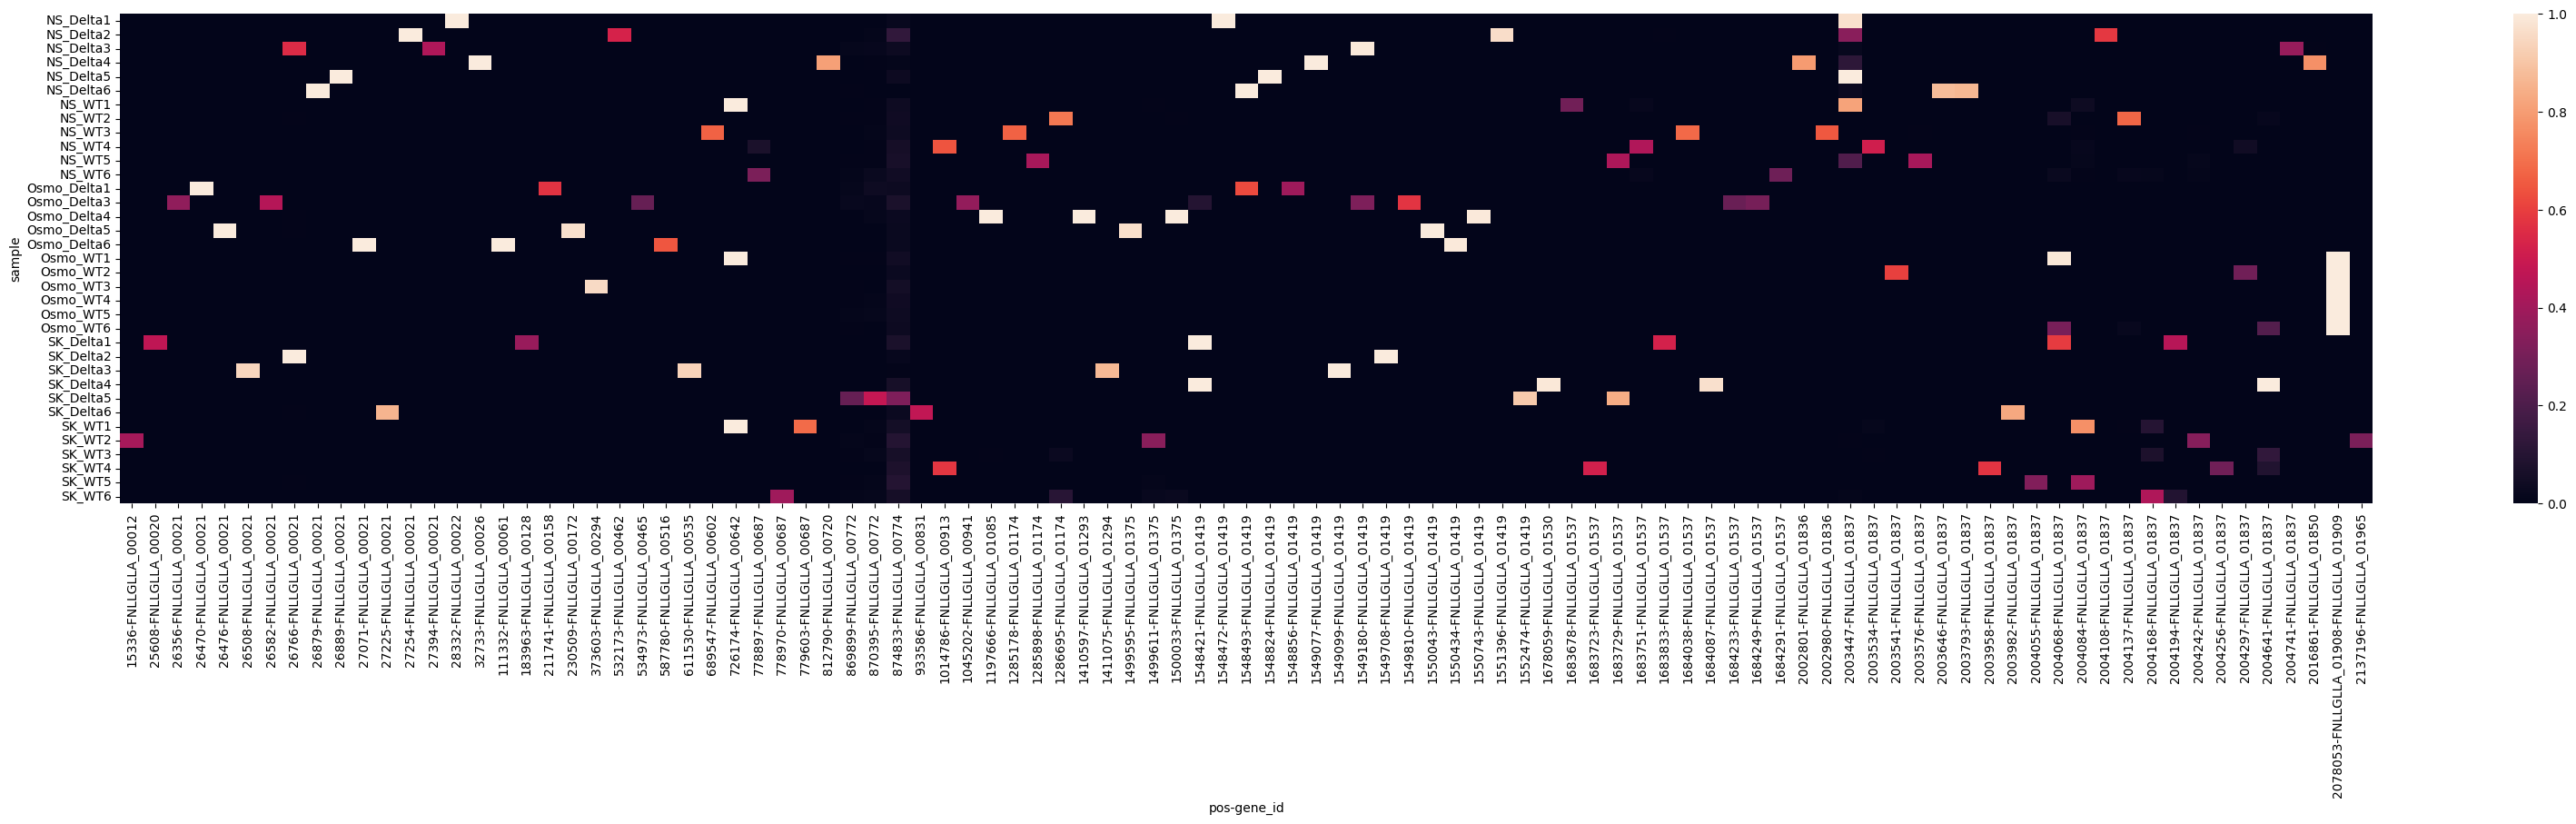

In [23]:
df = freq_filtered_freqs.set_index(
    ["chrom", "pos", "annot", "gene_id", "EFF_class", "Annotation_Impact"],
    append=True).stack().reset_index().set_index(
        ["SNP", "chrom", "annot", "EFF_class", "Annotation_Impact"]).pivot(
            index="sample", columns=["pos", "gene_id"])
#df.columns = ["pos", "sample", "freq"]
#df.pivot(index="pos", columns="sample", values="freq")
df.columns = df.columns.droplevel(0)
fig, ax = plt.subplots(1, 1, figsize=(40, len(selection) // 5))
sns.heatmap(df, ax=ax)
plt.savefig(
    outdir.joinpath("SNP_freq_heatmap_end_points.png"),
    dpi=300)